In [56]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from extinctions import *
from preprocessing import *

In [38]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
scatter_simple = (band_centers/500)**(-1.2)

absorption for 80% water, 10% lipids, 50microMol hemoglobin, 2micloMol cytochrome

(520.0, 900.0)

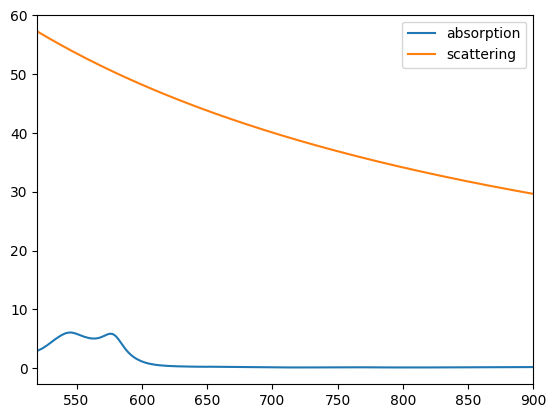

In [54]:
mu_a = 0.8*water + 0.1*fat + (25*hb + 25*hbo2 + 1*cyt_c_ox + 1*cyt_c_red + 1*cyt_b_ox + 1*cyt_b_red + 1*cyt_oxi_ox + 1*cyt_oxi_red)/1000
mu_s = 60*scatter_simple

plt.plot(band_centers, mu_a, label="absorption")
plt.plot(band_centers, mu_s, label="scattering")
plt.legend()
plt.xlim(bands_range)

(520.0, 900.0)

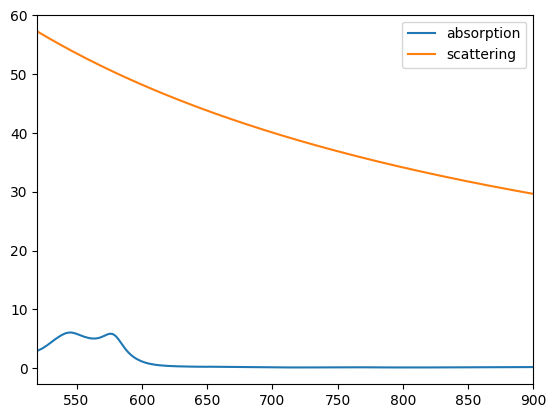

In [164]:
mu_a = 0.8*water + 0.1*fat + (25*hb + 25*hbo2 + 1*cyt_c_ox + 1*cyt_c_red + 1*cyt_b_ox + 1*cyt_b_red + 1*cyt_oxi_ox + 1*cyt_oxi_red)/1000
mu_s = 60*scatter_simple

plt.plot(band_centers, mu_a, label="absorption")
plt.plot(band_centers, mu_s, label="scattering")
plt.legend()
plt.xlim(bands_range)

Generate input file following .mci format:

1.0                      	# file version\\
1                        	# number of runs\\

\### RUN for ... nm\\
sample.mco 	A	      		# output file name, ASCII.\\
100000                  	# No. of photons\\
100000000	1               # dz, dr [cm]\\
1	1	1                	# No. of dz, dr, da.\\
1                        	# Number of layers\\
#n mua mus	g	d         	# One line for each layer\\
1                         	# n for medium above\\
1.4	0.1	90	0.9	100000000	# layer 1\\
1                        	# n for medium below\\

In [165]:
n_photons = 100000
dz, dr = 100000000, 1
g = 0.9
d = 1e8
name = "baseline"

output_folder = f"output_{name}"
os.makedirs(output_folder, exist_ok=True)
# create new .mci file
f = open(f"input_{name}.mci", "w")
f.write("1.0    # file version\n")
f.write(f"{band_centers.shape[0]}    # number of runs\n")

for i in range(band_centers.shape[0]):
    f.write("\n")
    f.write(f"### RUN for {band_centers[i]} nm\n")
    output_file = os.path.join(output_folder,f"{band_centers[i]}.mco")
    f.write(f"{output_file}  A    # output file\n")
    f.write(f"{n_photons}    # No. of photons\n")
    f.write(f"{dz}  {dr}    # dz, dr\n")
    f.write(f"1  1  1    # No. of dz, dr, da\n")
    f.write(f"1    # Number of layers\n")
    f.write(f"#n  mu_a  mu_s  g  d\n")
    f.write(f"1    # n for medium above\n")
    f.write(f"1.4  {mu_a[i]}  {mu_s[i]}  {g}  {int(d)}\n")
    f.write(f"1    # n for medium below\n")
f.close()

Read reflectance data from output files

In [169]:
name = "baseline"

output_folder = f"output_{name}"
R_spec = np.zeros(band_centers.shape[0])
R_diff = np.zeros(band_centers.shape[0])
for i in range(band_centers.shape[0]):
    output_file = os.path.join(output_folder,f"{band_centers[i]}.mco")
    f = open(output_file, "r")
    for line in f:
        if "Specular reflectance" in line:
            R_spec[i] = float(line.split()[0])
        if "Diffuse reflectance" in line:
            R_diff[i] = float(line.split()[0])
    f.close()

# save R_diff as text file
np.savetxt(f"R_{name}.txt", R_diff)

Text(0.5, 1.0, 'Absorbance')

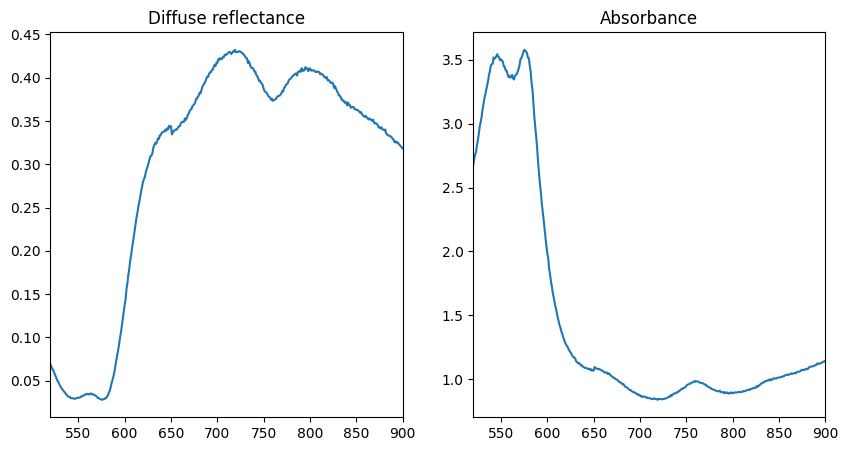

In [170]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True)
# plt.plot(band_centers, R_spec, label="R_spec")
axs[0].plot(band_centers, R_diff, label="R_diffuse")
axs[0].set_xlim(bands_range)
axs[0].set_title("Diffuse reflectance")

R_diff_smooth = smooth_spectral(R_diff)
absorbance = -np.log(R_diff)
axs[1].plot(band_centers, absorbance, label="absorbance")
# axs[1].set_xlim(bands_range)
axs[1].set_title("Absorbance")

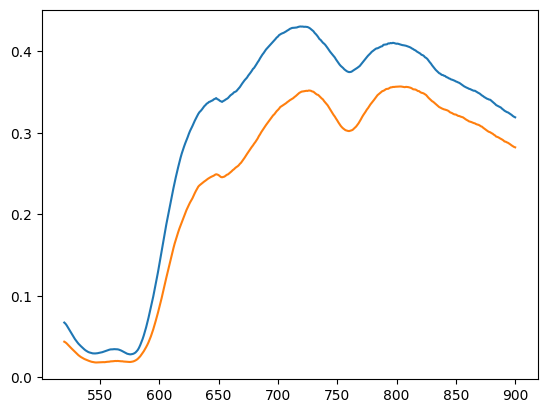

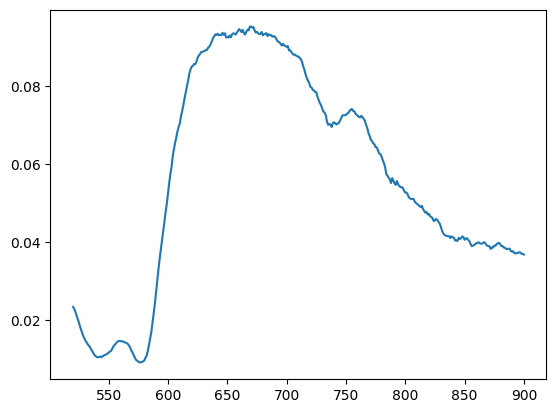

In [171]:
# load R_baseline and R_water90
R_baseline = np.loadtxt("R_baseline.txt")
R = np.loadtxt("R_hhb_50.txt")
R_baseline = smooth_spectral(R_baseline)
R = smooth_spectral(R)

plt.plot(band_centers, R_baseline, label="R_baseline")
plt.plot(band_centers, R, label="R_water90")

dR = R_baseline - R
hb_mc = -np.log(dR)
plt.figure()
plt.plot(band_centers, dR, label="dR")

### try OSP with new spectrum

In [124]:
data_folder = "../../datasets/helicoid/012-01"
# data_folder = "../../datasets/helicoid/008-01"

class_labels = ["Not labled", "Normal", "Tumor", "Hypervascularized", "Background"]
# class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")
# plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)

# preprocessing
img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
img_smooth = smooth_spectral(img_calib_norm, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

# select random spectrum from normal class
np.random.seed(1)
normal_idx = np.argwhere(gt_map.asarray() == 1)
random_idx = np.random.choice(normal_idx.shape[0])
reference_spectrum = absorbance[normal_idx[random_idx,0], normal_idx[random_idx,1], :]

# calculate absorbance difference between the selected spectrum and the rest of the image
delta_absorbance = absorbance - reference_spectrum[None,None,:]

c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [116]:
def osp(abs, endmembers_proj, endmember_target, device="cpu"):
    '''
    Project the image spectra in the subspace orthogonal to the spectra in endmembers_proj.
    input:
        abs: absorbance array to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers_proj: endmember spectra to remove, shape (n, k), where n is the number of endmembers
        endmember_target: target endmember to detect, shape (k,)
    output:
        abs_proj: target heatmap, shape (...)
    '''
    P = np.eye(endmembers_proj.shape[1]) - endmembers_proj.T @ np.linalg.pinv(endmembers_proj).T
    # convert to torch tensors
    P = torch.from_numpy(P).to(device).float()
    abs = torch.from_numpy(abs).to(device).float()
    s = torch.from_numpy(endmember_target).to(device).float()
    # project data
    abs_proj = torch.einsum('ik,...k->...i', P, abs)
    # calculate target heatmap
    abs_proj = torch.einsum('k,...k->...', s, abs_proj).cpu().numpy()
    return abs_proj

def clip_data(data, lower=1, upper=99):
    '''
    Clip the data to the specified percentiles along the first two axes.
    input:
        data: np.array, shape (N, M, ...)
        lower: int, lower percentile
        upper: int, upper percentile
    output:
        data: np.array, shape (N, M, ...)
    '''
    lower_clip = np.percentile(data, lower, axis=(0,1), keepdims=True)
    upper_clip = np.percentile(data, upper, axis=(0,1), keepdims=True)
    data = np.clip(data, lower_clip, upper_clip)
    return data

In [172]:
# load MC simulation results
R_baseline = np.loadtxt("R_baseline.txt")
R_hb50 = np.loadtxt("R_hb50.txt")
R_hbO250 = np.loadtxt("R_hbO250.txt")

# smooth the spectra
R_baseline = smooth_spectral(R_baseline)
R_hb50 = smooth_spectral(R_hb50)
R_hbO250 = smooth_spectral(R_hbO250)

# compute endmember relative absorbance
hb_mc = -np.log(R_baseline - R_hb50)
hbo2_mc = -np.log(R_baseline - R_hbO250)

# OSP using spectra from MC simulations
M_scatter_new = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb_mc, hbo2_mc, water, fat, scatter_simple)).T
M_scatter_new_smooth = smooth_spectral(M_scatter_new.T,5).T

endmembers_remove = np.delete(M_scatter_new_smooth, 6, axis=1).T
data_hb_mc = osp(delta_absorbance, endmembers_remove, hb_mc)
endmembers_remove = np.delete(M_scatter_new_smooth, 7, axis=1).T
data_hbo2_mc = osp(delta_absorbance, endmembers_remove, hbo2_mc)


# OSP using spectra from literature
M_scatter_orig = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_simple)).T
M_scatter_orig_smooth = smooth_spectral(M_scatter_orig.T,5).T

endmembers_remove = np.delete(M_scatter_orig_smooth, 6, axis=1).T
data_hb = osp(delta_absorbance, endmembers_remove, hb)
endmembers_remove = np.delete(M_scatter_orig_smooth, 7, axis=1).T
data_hbo2 = osp(delta_absorbance, endmembers_remove, hbo2)

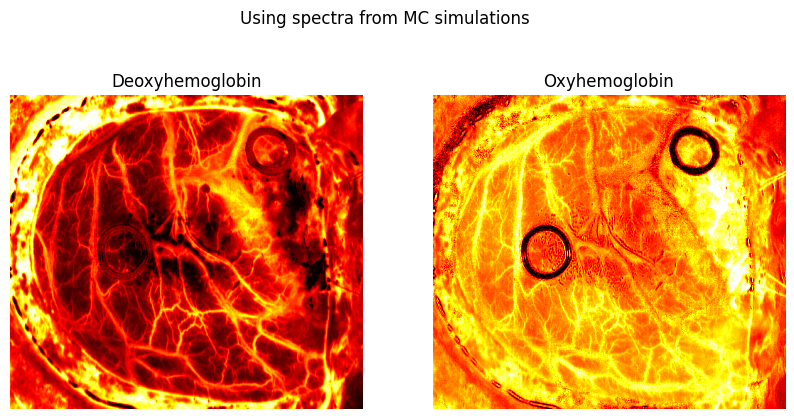

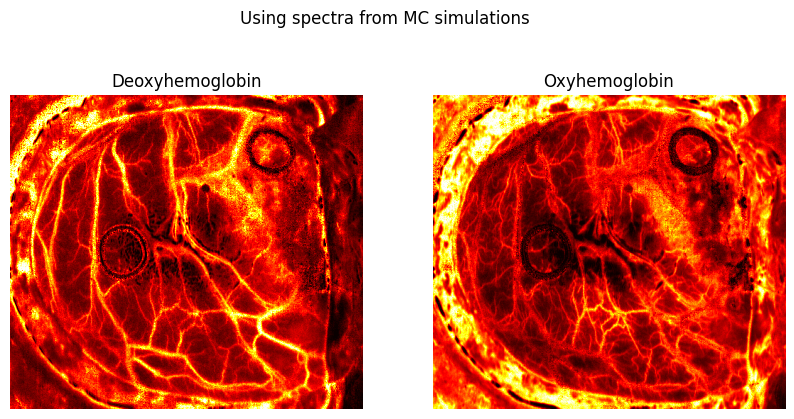

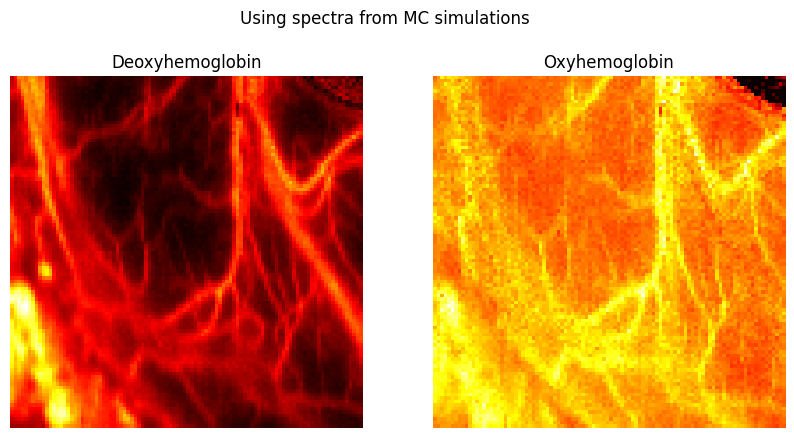

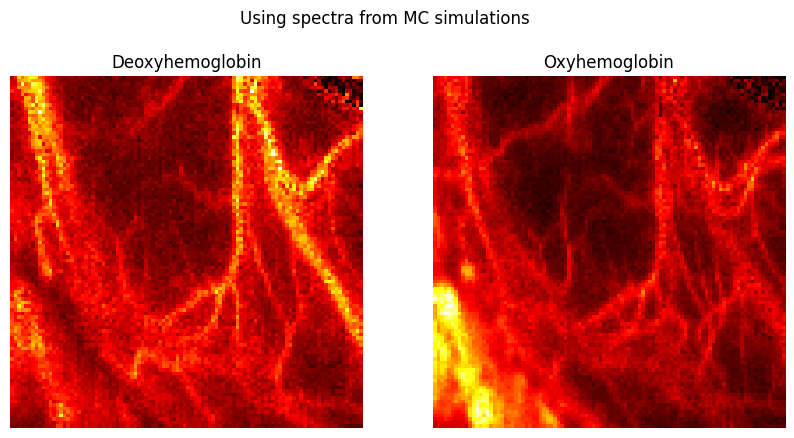

In [173]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Using spectra from MC simulations")
axs[0].imshow(clip_data(data_hb_mc), cmap="hot")
axs[0].set_title("Deoxyhemoglobin")
axs[0].set_axis_off()
axs[1].imshow(clip_data(data_hbo2_mc), cmap="hot")
axs[1].set_title("Oxyhemoglobin")
axs[1].set_axis_off()

fig, axs = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Using spectra from MC simulations")
axs[0].imshow(clip_data(data_hb), cmap="hot")
axs[0].set_title("Deoxyhemoglobin")
axs[0].set_axis_off()
axs[1].imshow(clip_data(data_hbo2), cmap="hot")
axs[1].set_title("Oxyhemoglobin")
axs[1].set_axis_off()


fig, axs = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Using spectra from MC simulations")
axs[0].imshow(clip_data(data_hb_mc)[250:350,50:150], cmap="hot")
axs[0].set_title("Deoxyhemoglobin")
axs[0].set_axis_off()
axs[1].imshow(clip_data(data_hbo2_mc)[250:350,50:150], cmap="hot")
axs[1].set_title("Oxyhemoglobin")
axs[1].set_axis_off()

fig, axs = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Using spectra from MC simulations")
axs[0].imshow(clip_data(data_hb)[250:350,50:150], cmap="hot")
axs[0].set_title("Deoxyhemoglobin")
axs[0].set_axis_off()
axs[1].imshow(clip_data(data_hbo2)[250:350,50:150], cmap="hot")
axs[1].set_title("Oxyhemoglobin")
axs[1].set_axis_off()